Housekeeping

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)

Load File

In [3]:
data = pd.read_csv('product_unenrollment_data.csv', index_col=0)

Run Summary Statistics

In [4]:
deets = data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age_nr                          10000 non-null  int64  
 1   invest_exp_nm                   8018 non-null   object 
 2   trades_6mo_nr                   10000 non-null  int64  
 3   web_logins_3mo_nr               10000 non-null  int64  
 4   app_logins_3mo_nr               10000 non-null  int64  
 5   total_assets_am                 10000 non-null  float64
 6   product_assets_am               10000 non-null  float64
 7   net_new_assets_am               10000 non-null  float64
 8   total_portfolio_return_1yr_pct  10000 non-null  float64
 9   product_tenure_mths_nr          10000 non-null  int64  
 10  calls_12mo_nr                   10000 non-null  int64  
 11  emails_12mo_nr                  10000 non-null  int64  
 12  meetings_12mo_nr                

In [5]:
overview = data.describe()
print(overview)

             age_nr  trades_6mo_nr  web_logins_3mo_nr  app_logins_3mo_nr  total_assets_am  product_assets_am  net_new_assets_am  total_portfolio_return_1yr_pct  product_tenure_mths_nr  calls_12mo_nr  emails_12mo_nr  meetings_12mo_nr  unenrollment_in
count  10000.000000   10000.000000       10000.000000       10000.000000     1.000000e+04       1.000000e+04       1.000000e+04                    10000.000000            10000.000000   10000.000000    10000.000000      10000.000000     10000.000000
mean      65.392500      10.002600           8.996900           6.998000     2.292031e+06       1.869727e+06       9.291974e+04                        0.069865               92.645600       9.003200       24.001100          6.000200         0.092800
std       13.919347       3.163288           2.996997           2.642327     4.132888e+06       3.002134e+06       1.592311e+05                        0.029963               83.158632       3.007373        4.898806          2.448224         0.290166


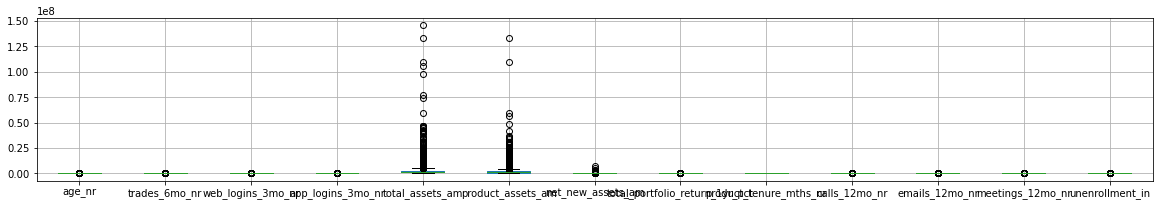

In [30]:
boxPlot = data.boxplot(figsize=(20, 3))

In [7]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,age_nr,trades_6mo_nr,web_logins_3mo_nr,app_logins_3mo_nr,total_assets_am,product_assets_am,net_new_assets_am,total_portfolio_return_1yr_pct,product_tenure_mths_nr,calls_12mo_nr,emails_12mo_nr,meetings_12mo_nr,unenrollment_in
age_nr,1.00,-0.01,0.00,0.01,-0.04,-0.03,-0.03,-0.00,0.01,0.01,0.01,0.01,-0.01
trades_6mo_nr,-0.01,1.00,0.38,0.18,0.02,0.02,0.01,0.02,0.01,0.34,0.17,0.12,0.08
web_logins_3mo_nr,0.00,0.38,1.00,0.37,-0.00,0.00,0.00,0.02,0.00,0.14,0.32,0.53,0.03
app_logins_3mo_nr,0.01,0.18,0.37,1.00,-0.01,-0.00,-0.01,0.02,0.01,0.32,0.36,0.06,0.01
total_assets_am,-0.04,0.02,-0.00,-0.01,1.00,0.80,0.76,-0.01,0.02,-0.01,0.00,-0.01,0.02
product_assets_am,-0.03,0.02,0.00,-0.00,0.80,1.00,0.95,-0.00,0.01,-0.01,0.00,-0.01,-0.10
net_new_assets_am,-0.03,0.01,0.00,-0.01,0.76,0.95,1.00,-0.00,0.01,-0.01,-0.01,-0.01,-0.12
total_portfolio_return_1yr_pct,-0.00,0.02,0.02,0.02,-0.01,-0.00,-0.00,1.00,-0.01,0.01,0.01,0.02,-0.01
product_tenure_mths_nr,0.01,0.01,0.00,0.01,0.02,0.01,0.01,-0.01,1.00,0.01,-0.01,0.01,-0.12
calls_12mo_nr,0.01,0.34,0.14,0.32,-0.01,-0.01,-0.01,0.01,0.01,1.00,0.05,0.25,0.09


Observations

1. invest_exp_nm is the only categorical variable. Will make this into a dummy
2. Some big outliers in the *total assets* and *product asset* categories. (I assumed its safe to exclude these, model will behave a lot better. IRL I would make a note to do a "large account" analysis in the future)
3. Most of the features are normally distributed, the only exception is product tenure. The 3 asset features have heavy skew.
4. All 3 asset features are highly correlated, so we need to address that in the model. (only because we'd like to understand the factors behind the predicions)
5. There is another correlation cluster between the logins and communication methods, but it is moderate. I'd like to explore more if time permits.

Cleanup

1. Keep only assets within 2 sds
2. Delete unused columns 
    1. customer_id: used as index
    2. total_assets_am: highly correlated with product_assets_am (removed since model is about this specific product, "total assets" includes other products)
    3. net_new_assets_am: highly correlated with product_assets_am (removed since model is about this specific product, "net new assets" includes other customer accounts)
3. Scale remining "product assets" column by 1000 so the numbers are not as extreme.
4. Encode invest_exp_nm into dummies

In [8]:
df_clean = data.drop(['total_assets_am','net_new_assets_am'], axis=1)
df_clean['product_assets_am'] = (df_clean['product_assets_am'] / 10000)

In [9]:
p_asset_threshold = np.percentile(df_clean.product_assets_am,  95.45)

In [10]:
df_clean = df_clean[ df_clean['product_assets_am'] < p_asset_threshold ]

In [11]:

exp_dummies = pd.get_dummies(df_clean['invest_exp_nm'], prefix='exp', dummy_na=False, drop_first=False)
print(exp_dummies.head())

             exp_excellent  exp_good  exp_limited  exp_none
customer_id                                                
1                        0         0            1         0
2                        0         1            0         0
3                        0         1            0         0
4                        0         0            1         0
5                        1         0            0         0


In [12]:
#df_clean = pd.concat([df_clean, exp_dummies], axis=1) #removed dummies after seeing how they were affecting the model
df_clean.drop(['invest_exp_nm'], axis=1, inplace=True) #removed age after seeing no predictive power
print(df_clean.head())

             age_nr  trades_6mo_nr  web_logins_3mo_nr  app_logins_3mo_nr  product_assets_am  total_portfolio_return_1yr_pct  product_tenure_mths_nr  calls_12mo_nr  emails_12mo_nr  meetings_12mo_nr  unenrollment_in
customer_id                                                                                                                                                                                                          
1                62             19                  9                  5         140.597204                          0.0679                      27              5              23                 7                0
2                69              8                  8                  5          52.806373                          0.0539                     140              7              23                 6                0
3                66              8                  8                  6         164.324659                          0.0662                     

In [13]:
stat = df_clean.describe()
#stat.to_csv("schwab_basicstats.csv")

array([[<AxesSubplot:title={'center':'trades_6mo_nr'}>,
        <AxesSubplot:title={'center':'web_logins_3mo_nr'}>,
        <AxesSubplot:title={'center':'app_logins_3mo_nr'}>],
       [<AxesSubplot:title={'center':'product_assets_am'}>,
        <AxesSubplot:title={'center':'total_portfolio_return_1yr_pct'}>,
        <AxesSubplot:title={'center':'product_tenure_mths_nr'}>],
       [<AxesSubplot:title={'center':'calls_12mo_nr'}>,
        <AxesSubplot:title={'center':'emails_12mo_nr'}>,
        <AxesSubplot:title={'center':'meetings_12mo_nr'}>]], dtype=object)

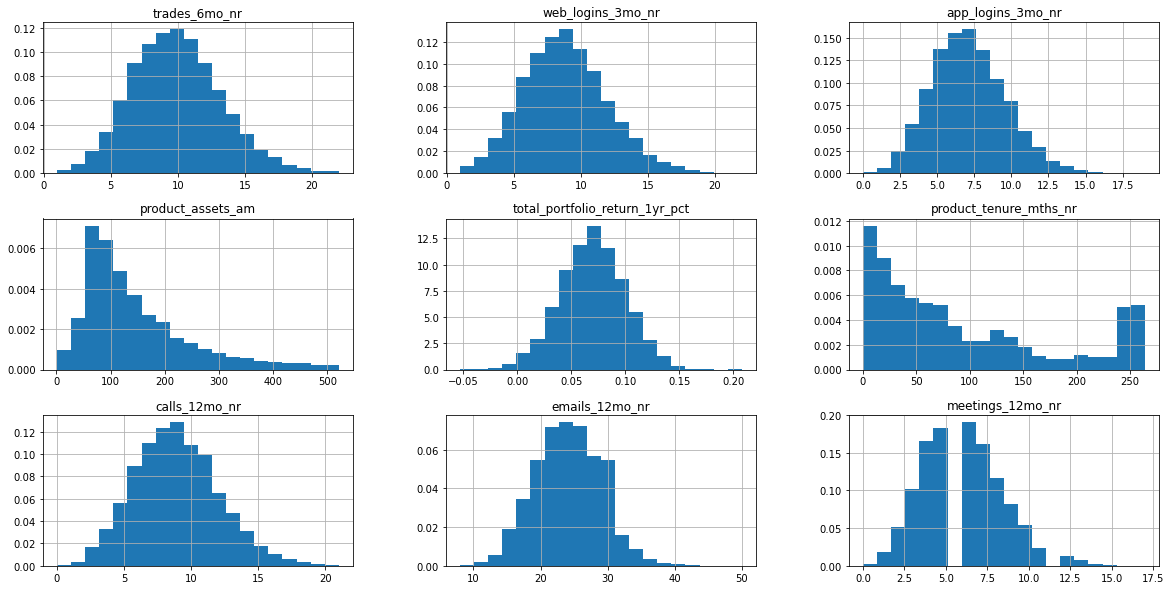

In [31]:
df_clean.iloc[:,:-1].hist(figsize=(20, 10),bins=20, density=True)

In [15]:
corr = df_clean.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,age_nr,trades_6mo_nr,web_logins_3mo_nr,app_logins_3mo_nr,product_assets_am,total_portfolio_return_1yr_pct,product_tenure_mths_nr,calls_12mo_nr,emails_12mo_nr,meetings_12mo_nr,unenrollment_in
age_nr,1.00,-0.01,0.00,0.01,0.00,-0.00,0.01,0.01,0.01,0.01,-0.01
trades_6mo_nr,-0.01,1.00,0.38,0.18,0.00,0.02,0.02,0.35,0.17,0.12,0.08
web_logins_3mo_nr,0.00,0.38,1.00,0.37,0.02,0.02,0.01,0.14,0.32,0.53,0.03
app_logins_3mo_nr,0.01,0.18,0.37,1.00,0.01,0.02,0.01,0.32,0.36,0.07,0.01
product_assets_am,0.00,0.00,0.02,0.01,1.00,-0.01,-0.00,-0.00,0.00,0.01,-0.16
total_portfolio_return_1yr_pct,-0.00,0.02,0.02,0.02,-0.01,1.00,-0.01,0.01,0.01,0.02,-0.01
product_tenure_mths_nr,0.01,0.02,0.01,0.01,-0.00,-0.01,1.00,0.01,-0.01,0.01,-0.12
calls_12mo_nr,0.01,0.35,0.14,0.32,-0.00,0.01,0.01,1.00,0.06,0.25,0.09
emails_12mo_nr,0.01,0.17,0.32,0.36,0.00,0.01,-0.01,0.06,1.00,0.30,0.02
meetings_12mo_nr,0.01,0.12,0.53,0.07,0.01,0.02,0.01,0.25,0.30,1.00,0.01


#### Start Modeling Process

Choosing logistic regression because it meets the follwoing criteria:
1. Interpretability of coefficients
2. Binary Outcome - we want a probabilistic model that behaves well in the 0-1 range
3. We have removed highly muticollinear variables, so independent assumptions holds for the most part


In [16]:
df_clean.drop(['age_nr'], axis=1, inplace=True)
df_clean.to_csv("df_clean_ue2.csv")

In [17]:
test_pct = .2

In [18]:
Y = df_clean['unenrollment_in']
X = df_clean.drop('unenrollment_in', axis=1)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_pct, random_state=0)

XY_train = pd.concat([Y_train, X_train], axis=1)
XY_test = pd.concat([Y_test, X_test], axis=1)


Import Goodies

In [20]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

#### Logistic Regression

Accuracy Score: 0.8968046097433211
Area Under Curve: 0.4997081144191477
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1713
           1       0.00      0.00      0.00       196

    accuracy                           0.90      1909
   macro avg       0.45      0.50      0.47      1909
weighted avg       0.81      0.90      0.85      1909



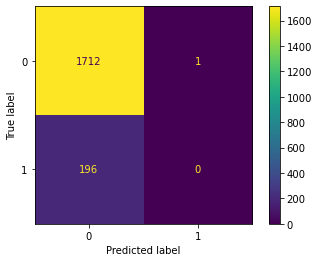

In [21]:


# define model
logit1 = LogisticRegression(random_state=5, solver='newton-cg',max_iter=10000, class_weight=None)
# fit it
logit1.fit(X_train,Y_train)
# test
Y_pred = logit1.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(Y_test,Y_pred)}')
print(f'Area Under Curve: {roc_auc_score(Y_test, Y_pred)}')

print(classification_report(Y_test, Y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, Y_pred), display_labels=logit1.classes_)
disp.plot()

Accuracy Score: 0.748035620743845
Area Under Curve: 0.683390519079786
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1713
           1       0.23      0.60      0.33       196

    accuracy                           0.75      1909
   macro avg       0.59      0.68      0.59      1909
weighted avg       0.87      0.75      0.79      1909



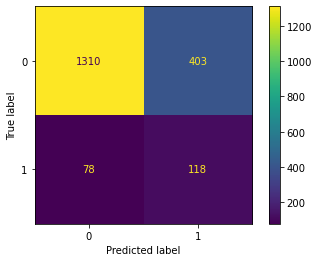

In [22]:
#define weights
w = {0:1, 1:7}

# define model
logit2 = LogisticRegression(random_state=1, solver='newton-cg',max_iter=10000, class_weight=w)
# fit it
logit2.fit(X_train,Y_train)
# test
Y_pred = logit2.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(Y_test,Y_pred)}')
print(f'Area Under Curve: {roc_auc_score(Y_test, Y_pred)}')

print(classification_report(Y_test, Y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, Y_pred), display_labels=logit2.classes_)
disp.plot()


#### XGBoost

Choosing xgboost as an alternate model because it meets the follwoing criteria:
1. Feature space is relatively small, so the tree structure will not bee to o hard to decipher/
2. Binary Outcome - we want a 2 class classifier
3. The model requires less data cleanup and is one of the most accurate out there, even though there's lots of hyperparameters to tweak.
4. Note: For this exercise, I ran it with the same training set as the logistic set just to compare metrics against the same set. In real life, IRL I would have optimized the input data set for XGB


[22:02:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\delao\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy Score: 0.8978522786799371
Area Under Curve: 0.5590293910909372
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1713
           1       0.51      0.13      0.21       196

    accuracy                           0.90      1909
   macro avg       0.71      0.56      0.58      1909
weighted avg       0.87      0.90      0.87      1909



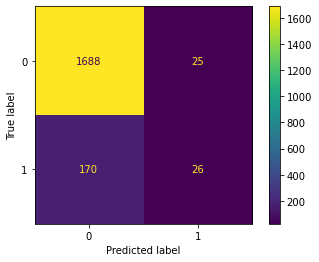

In [23]:


xgb1 = xgb.XGBClassifier()

xgb1.fit(X_train, Y_train)

Y_pred = xgb1.predict(X_test)

print(f'Accuracy Score: {accuracy_score(Y_test,Y_pred)}')
print(f'Area Under Curve: {roc_auc_score(Y_test, Y_pred)}')

print(classification_report(Y_test, Y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, Y_pred), display_labels=xgb1.classes_)
disp.plot()

[22:02:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\delao\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy Score: 0.7757988475641697
Area Under Curve: 0.6785282414191597
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      1713
           1       0.24      0.56      0.34       196

    accuracy                           0.78      1909
   macro avg       0.59      0.68      0.60      1909
weighted avg       0.87      0.78      0.81      1909



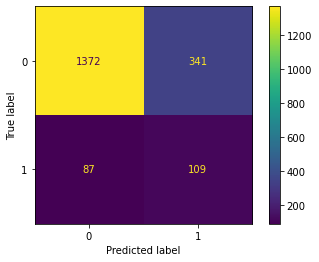

In [24]:

xgb2 = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.005, scale_pos_weight=8)

xgb2.fit(X_train, Y_train, early_stopping_rounds=5, eval_set=[(X_test, Y_test)], verbose=False)

Y_pred = xgb2.predict(X_test)

print(f'Accuracy Score: {accuracy_score(Y_test,Y_pred)}')
print(f'Area Under Curve: {roc_auc_score(Y_test, Y_pred)}')

print(classification_report(Y_test, Y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, Y_pred), display_labels=xgb1.classes_)
disp.plot()